In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

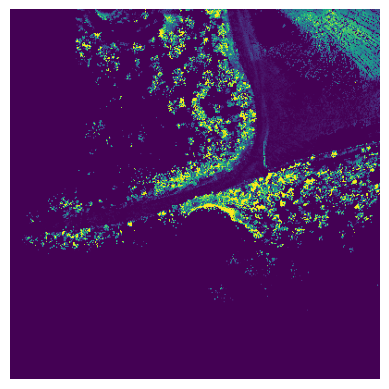

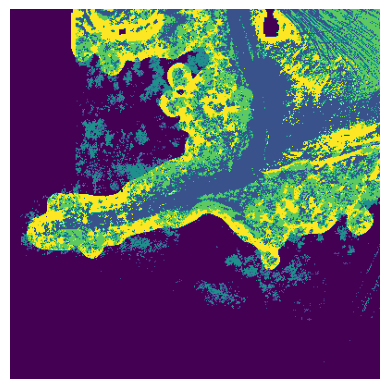

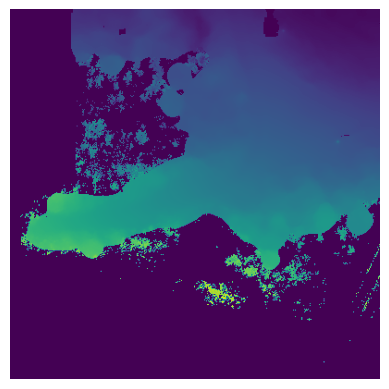

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/object_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/observed_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/terrain_map-150.png", bbox_inches='tight')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
import sys
from pathlib import Path

PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
sys.path.append(PATH_TO_SHARED_LIB)

from rrt_sharp_py import *

In [6]:
# Configure RRTSharp object

# Create Map dimension
rrt_sharp = RRTSharp([2, 3, 4])

rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
rrt_sharp.set_object_map(object_map.flatten().tolist())
rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
rrt_sharp.set_start_state(227.0, -143.0, 180.0)
rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
rrt_sharp.set_stop_radius(5.0)

# Run RRT

rrt_sharp.init()
rrt_sharp.run()

Reached
Reached
Reached
Reached
Reached
Reached
numNodes: 4582, numChildren: 4582
total: 1387.61 ms


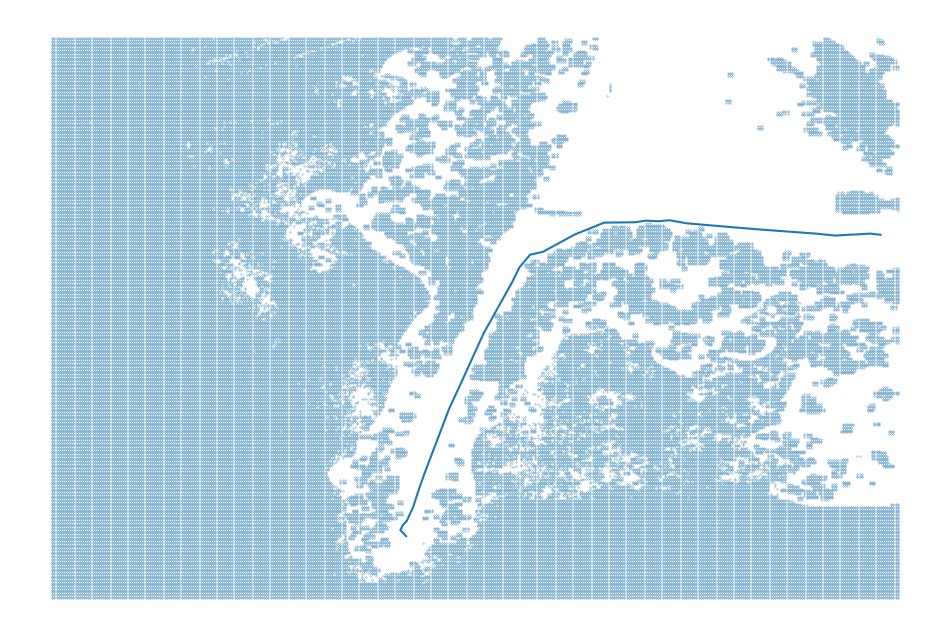

In [14]:
traj_x = np.array(list(rrt_sharp.get_trajectory_x()))
traj_y = np.array(list(rrt_sharp.get_trajectory_y()))

search_space_x = list(rrt_sharp.get_search_space_x())
search_space_y = list(rrt_sharp.get_search_space_y())

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)

plt.axis('off')
plt.savefig("assets/rrt-150.png", bbox_inches='tight')
plt.show()

# Simulating dynamics

In [15]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [16]:
model = bicycle_model.BicycleModelParameters(dt=0.02, max_steering_angle=3, min_steering_angle=-3, wheelbase=1)

# state: x, y, yaw, velocity

nx = 4
x0 = np.array([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = np.array([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.shape[0]+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-01]
 [4.40000000e-03 0.00000000e+00 0.00000000e+00 2.40000000e-01]
 [9.43999861e-03 3.74173093e-06 1.55905470e-03 2.64000000e-01]
 [1.49999787e-02 1.86159853e-05 3.90978499e-03 2.92000000e-01]
 [2.08399195e-02 4.49058146e-05 5.09361160e-03 2.92000000e-01]]


## Using iLQR to follow reference trajectory

Now, we need to convert `traj_x` and `traj_y` from RRT to corresponding `Xref` and `Uref` with correct sizes

In [20]:
N = max(traj_x.shape[0], traj_x.shape[0] * (250//traj_x.shape[0]))

# Upsample trajectories if necessary
if N > traj_x.shape[0]:
    upsampling_factor = 250//traj_x.shape[0]
    
    # Forming points
    points = np.dstack((traj_x, traj_y)).squeeze()
    
    # Forming groups of consecutive points
    n_groups = len(traj_x) - 1
    indices = np.arange(n_groups)[:, None] + np.array([0, 1])
    groups = points[indices]
    
    # We upsample by doing linear interpolation between points
    new_groups = np.linspace(groups[:, 0], groups[:, 1], 1+upsampling_factor, axis=1)
    
    # We merge the new points
    new_groups = new_groups[:, :-1, :] # skipping last point of each group to avoid duplicates
    new_points = np.vstack((new_groups.reshape((-1, 2)), points[None, -1, :])) # don't forget very last point
    
    traj_x = new_points[:, 0]
    traj_y = new_points[:, 1]
    
    N = traj_x.shape[0]
    
# create reference trajectory 
Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), 30*np.ones(N)]).T, np.zeros((N-1, nu))

angles = []

# Guess yaw angles
for k in range(len(Xref) - 1):
    p1 = Xref[k]
    p2 = Xref[k+1]
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) # tan^-1(Δy/Δx)
    angle = angle if angle > 0 else angle + 2*np.pi
    angles.append(angle)
angles.append(angles[-1])
    
last_angle = angles[0]
for k in range(len(Xref)):
    angle = angles[k]
    Xref[k, 2] = (last_angle + angle)/2 # average of yaw angles
    last_angle = angle

for k in range(len(Xref) - 1):
    # estimating the steering angle very roughly
    diff_angles = Xref[k+1, 2] - Xref[k, 2]
    Uref[k, 1] = diff_angles*1.4
Uref[-80:, 0] = 160
Uref[-50:, 0] = -140

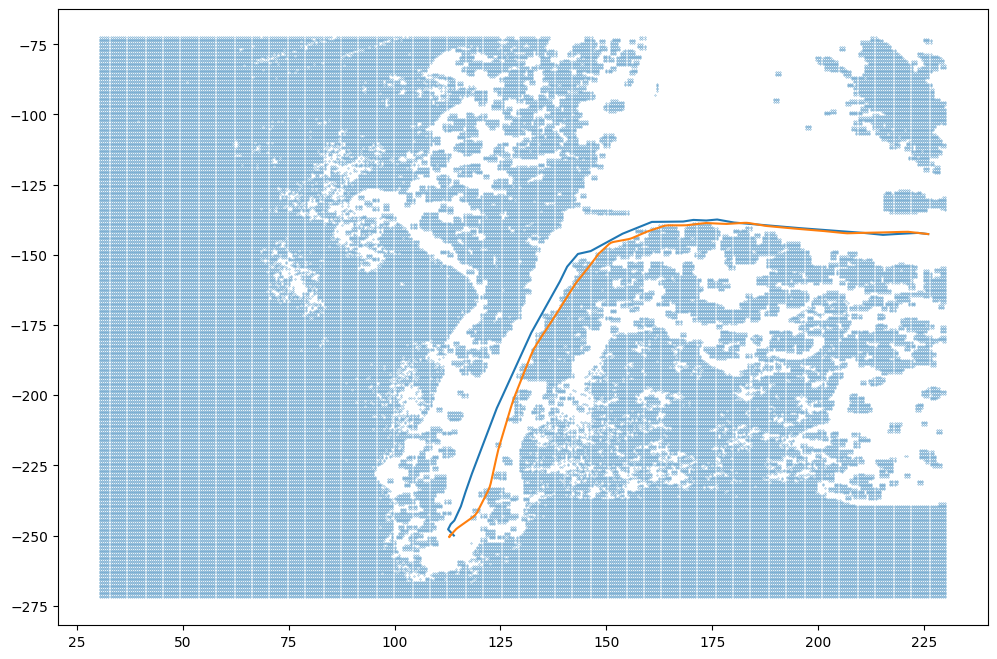

In [21]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

params.N = Uref.shape[0]+1
X = simulate(Xref[0], Uref, bicycle_model.discrete_dynamics, params)

Xref[:, 3] = X[:, 3] # update velocities with more accurate ones

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])
plt.show()

In [22]:
# problem size 
dt = model.dt

# tracking cost function
Q = np.diag([1, 1, 10, 10])
R = np.diag([0.01, 10])
Qf = 20*Q

# the params needed by iLQR 
qrParams = qr.QR(
    Q=Q,
    Qf=Qf,
    R=R,
    Xref=Xref,
    Uref=Uref,
    nx=params.nx,
    nu=params.nu,
    N=N,
    model=params.model
)

# initial condition 
x0 = Xref[0]

# initial guess controls 
U = Uref
U[:, 0] += 1e-10*np.random.normal(size=Uref.shape[0]) # for controllability

# solve with iLQR
X, U, K = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, bicycle_model.discrete_dynamics_grad, qrParams)

forward pass failed
iteration 16


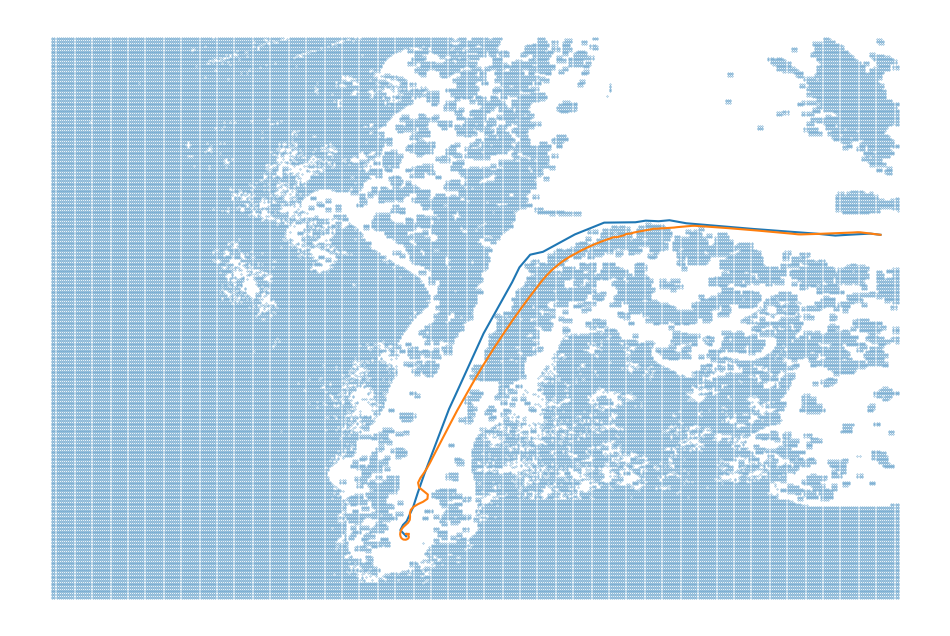

In [23]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])

plt.axis('off')
plt.savefig("assets/iLQR-150.png", bbox_inches='tight')
plt.show()